In [1]:
# Import Standard Libraries
import os
import tarfile
import time
import random
import glob
from PIL import Image
from collections import Counter
from tqdm.auto import tqdm
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Import PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from sklearn.metrics import precision_score, recall_score, f1_score

# Install and Import timm for transformer architecture
!pip install timm -q
import timm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the source and destination folder paths
def extract_all_tar_xz(source_folder_path, destination_folder_path):

    # Iterate through all files in the source folder
    for file_name in os.listdir(source_folder_path):
        if file_name.endswith('.tar.xz'):
            tar_file_path = os.path.join(source_folder_path, file_name)

            print(f"Extracting {file_name} into {destination_folder_path}...")

            # Extract the .tar.xz file directly into the destination folder
            with tarfile.open(tar_file_path, 'r:xz') as tar:
                tar.extractall(path=destination_folder_path)

            print(f"Finished extracting {file_name}.")

    print("All .tar.xz files have been successfully extracted.")

## Extract images

Make sure the labelled data is stored in .tar.xz, each tar containing one class, all this in a folder on your Google Drive. The name of the folders are bellow.




In [3]:
extract_all_tar_xz('/content/drive/MyDrive/Huron_Labelled_Data', '/content/Labeled_Data')
extract_all_tar_xz('/content/drive/MyDrive/Huron_Labelled_Data_4_Class', '/content/Labeled_Data_4_Class')
extract_all_tar_xz('/content/drive/MyDrive/Huron_Labelled_Data_2_Class', '/content/Labeled_Data_2_Class')

Extracting Preview_Tiles_Small_Fragmented_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Small_Fragmented_Tissue.tar.xz.
Extracting Preview_Tiles_Ink_Marks.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Ink_Marks.tar.xz.
Extracting Preview_Tiles_Faint_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Faint_Tissue.tar.xz.
Extracting Preview_Tiles_With_Some_Faint_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_With_Some_Faint_Tissue.tar.xz.
Extracting Preview_Tiles_Small_One_Piece_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Small_One_Piece_Tissue.tar.xz.
Extracting Preview_Tiles_With_No_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_With_No_Tissue.tar.xz.
Extracting Preview_Tiles_Large_Solid_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Large_Solid_Tissue.tar.xz.
All .tar.xz files 

In [4]:
# Function to remove hidden folders
def remove_hidden_folders(folder_path):
    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            if dir_name.startswith('.'):  # Hidden folder detection
                full_path = os.path.join(root, dir_name)
                print(f"Removing hidden folder: {full_path}")
                os.rmdir(full_path)

# Function to prepare datasets and DataLoaders
def prepare_datasets_and_loaders(data_dir, batch_size=32, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):

    # Clean hidden folders
    remove_hidden_folders(data_dir)

    # Define transformations for preprocessing
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])


    dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    valid_size = int(valid_ratio * dataset_size)
    test_size = dataset_size - train_size - valid_size

    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    # Create DataLoaders for each split
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Print dataset sizes and class-to-index mapping
    print("Class-to-Index Mapping:", dataset.class_to_idx)
    print(f"Total dataset size: {dataset_size}")
    print(f"Training set size: {len(train_dataset)}")

    return train_loader, dataset.class_to_idx

#Iterate through one batch from the train_loader
def print_batch_info(train_loader):
    for images, labels in train_loader:
        print(f"Batch size: {images.size()}, Labels: {labels}")
        break

In [5]:
# Prepare datasets and DataLoaders
train_loader_7_Class, class_to_idx_7_Class = prepare_datasets_and_loaders('/content/Labeled_Data')
print_batch_info(train_loader_7_Class)

train_loader_4_Class, class_to_idx_4_Class = prepare_datasets_and_loaders('/content/Labeled_Data_4_Class')
print_batch_info(train_loader_4_Class)

train_loader_2_Class, class_to_idx_2_Class = prepare_datasets_and_loaders('/content/Labeled_Data_2_Class')
print_batch_info(train_loader_2_Class)

Class-to-Index Mapping: {'Preview Tiles Small Fragmented tissue': 0, 'Preview Tiles Small One Piece Tissue': 1, 'Preview Tiles with No Tissue': 2, 'Preview Tiles with Some Faint Tissue': 3, 'Preview Tiles_Faint Tissue': 4, 'Preview Tiles_Ink Marks': 5, 'Preview Tiles_Large Solid Tissue': 6}
Total dataset size: 995
Training set size: 696
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([4, 0, 3, 5, 5, 6, 0, 0, 5, 0, 0, 2, 5, 5, 6, 1, 3, 6, 6, 6, 3, 6, 5, 0,
        4, 1, 4, 4, 3, 6, 3, 6])
Class-to-Index Mapping: {'Preview Tiles Small Fragmented tissue': 0, 'Preview Tiles with No Tissue': 1, 'Preview Tiles_Ink Marks': 2, 'Preview Tiles_Large Solid Tissue': 3}
Total dataset size: 653
Training set size: 457
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([3, 0, 3, 3, 3, 3, 0, 3, 1, 3, 2, 1, 3, 3, 0, 2, 3, 3, 3, 3, 3, 1, 0, 3,
        3, 3, 0, 2, 3, 3, 3, 1])
Class-to-Index Mapping: {'Preview Tiles with Some Faint Tissue': 0, 'Preview Tiles_Faint Tissue': 1}
Total datase

In [6]:
def intialize_model(checkpoint_path, num_classes, device):
    # Create the backbone model and classification head
    backbone = timm.create_model('vit_base_patch8_224', pretrained=True)
    in_dim = backbone.head.in_features

    classification_head = nn.Sequential(
        nn.Linear(in_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_classes)
    )

    backbone.head = classification_head
    backbone = backbone.to(device)

    # Load checkpoint
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        #print(f"KEys: {checkpoint.keys()}")

        student_backbone_state_dict = checkpoint

        model_state_dict = backbone.state_dict()
        filtered_checkpoint = {k: v for k, v in student_backbone_state_dict.items() if k in model_state_dict}

        missing_keys, unexpected_keys = backbone.load_state_dict(filtered_checkpoint, strict=False)

        # Print warnings if there are missing or unexpected keys
        if missing_keys:
            print(f"Warning: Missing keys during loading: {missing_keys}")
        if unexpected_keys:
            print(f"Warning: Unexpected keys during loading: {unexpected_keys}")




    else:
        print(f"Checkpoint not found at {checkpoint_path}. Starting with a fresh model.")

    # Test the model with dummy data
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    output = backbone(dummy_input)
    print("Output shape:", output.shape)  # Should be [1, num_classes]

    return backbone

## Load PreTrain model and add head

Downloading backbone:
Go to [the dino github page](https://github.com/facebookresearch/dino?tab=readme-ov-file#pretrained-models-on-pytorch-hub) and download the ViT-B/8 backbone only .pth file. Make a folder named "checkpoints" and add the file to it

In [7]:
checkpoint_path = '/content/checkpoints/dino_vitbase8_pretrain.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


backbone_7_class = intialize_model(checkpoint_path, 7, device)
backbone_4_class = intialize_model(checkpoint_path, 4, device)
backbone_2_class = intialize_model(checkpoint_path, 2, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading checkpoint from: /content/checkpoints/dino_vitbase8_pretrain.pth


<ipython-input-6-558a4b26933b>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Output shape: torch.Size([1, 7])
Loading checkpoint from: /content/checkpoints/dino_vitbase8_pretrain.pth
Output shape: torch.Size([1, 4])
Loading checkpoint from: /content/checkpoints/dino_vitbase8_pretrain.pth
Output shape: torch.Size([1, 2])


In [8]:
# Calculate class weights for imbalanced datasets
def get_class_weights(train_loader):
    class_counts = Counter([label for _, label in train_loader.dataset])
    class_weights = [1.0 / class_counts[c] for c in range(len(class_counts))]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Convert class weights to a tensor
    class_weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

    # Output the class counts
    print("Class Counts:", class_counts)
    print("Class Weights:", class_weights)

    return class_weights

In [9]:
# Get a random batch from the training DataLoader
def random_image(train_loader, backbone):
    random_batch = next(iter(train_loader))
    images, labels = random_batch

    # Select a random image from the batch
    random_idx = random.randint(0, images.size(0) - 1)
    random_image = images[random_idx]
    random_label = labels[random_idx]

    # Display the random image
    plt.imshow(random_image.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Random Image from Training Dataset (Label: {random_label.item()})")
    plt.axis('off')
    plt.show()

    preprocessed_image = random_image.unsqueeze(0).to(device)

    # Check the preprocessed image
    print(f"Preprocessed Image Shape: {preprocessed_image.shape}")
    print(f"Preprocessed Image Tensor (First Channel):\n{preprocessed_image[0, 0]}")

    # Pass the image through the backbone encoder
    backbone.eval()
    with torch.no_grad():
        intermediate_results = []

        # Forward pass through the patch embedding layer
        patch_embed = backbone.patch_embed(preprocessed_image)
        print(f"Patch Embedding Shape: {patch_embed.shape}")
        intermediate_results.append(("Patch Embedding", patch_embed.cpu().numpy()))

        # Forward pass through the transformer blocks
        transformer_output = patch_embed
        for idx, block in enumerate(backbone.blocks):
            transformer_output = block(transformer_output)
            print(f"Transformer Block {idx + 1} Output Shape: {transformer_output.shape}")
            intermediate_results.append((f"Transformer Block {idx + 1}", transformer_output.cpu().numpy()))

        # Forward pass through the head (classification head)
        cls_token = transformer_output[:, 0]
        logits = backbone.head(cls_token)
        print(f"Logits Shape: {logits.shape}")
        intermediate_results.append(("Logits", logits.cpu().numpy()))

    # Display final logits
    print(f"Final Logits: {logits}")


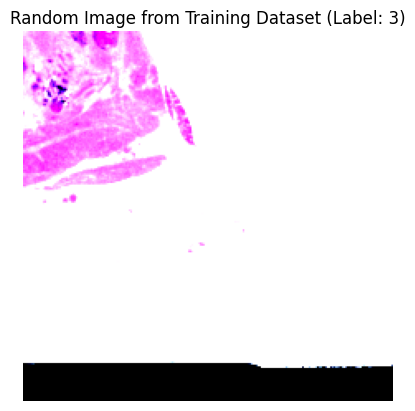

Preprocessed Image Shape: torch.Size([1, 3, 224, 224])
Preprocessed Image Tensor (First Channel):
tensor([[ 1.9920,  1.8893,  1.7865,  ...,  2.1804,  2.2147,  2.2147],
        [ 2.1462,  1.9920,  1.9920,  ...,  2.1804,  2.2147,  2.2147],
        [ 2.2147,  2.1633,  1.9749,  ...,  2.2147,  2.2147,  2.2318],
        ...,
        [-2.0494, -2.0837, -2.1008,  ..., -2.1008, -2.0837, -2.0837],
        [-2.0665, -2.0665, -2.0494,  ..., -2.1008, -2.0665, -2.0837],
        [-2.0665, -2.0494, -2.0665,  ..., -2.0837, -2.0837, -2.0837]],
       device='cuda:0')
Patch Embedding Shape: torch.Size([1, 784, 768])
Transformer Block 1 Output Shape: torch.Size([1, 784, 768])
Transformer Block 2 Output Shape: torch.Size([1, 784, 768])
Transformer Block 3 Output Shape: torch.Size([1, 784, 768])
Transformer Block 4 Output Shape: torch.Size([1, 784, 768])
Transformer Block 5 Output Shape: torch.Size([1, 784, 768])
Transformer Block 6 Output Shape: torch.Size([1, 784, 768])
Transformer Block 7 Output Shape: t

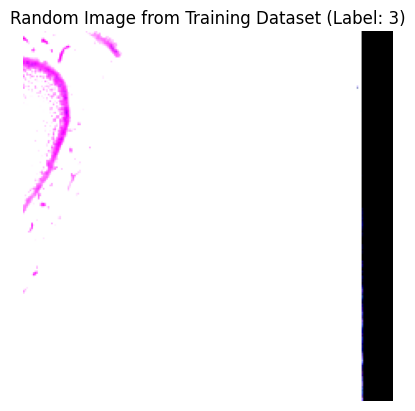

Preprocessed Image Shape: torch.Size([1, 3, 224, 224])
Preprocessed Image Tensor (First Channel):
tensor([[ 2.2489,  2.2489,  2.1975,  ..., -2.0494, -2.0665, -2.0665],
        [ 2.2318,  2.2489,  2.2489,  ..., -2.0494, -2.0494, -2.0494],
        [ 2.1462,  2.2489,  2.2489,  ..., -2.0152, -2.0665, -2.0323],
        ...,
        [ 2.2489,  2.2489,  2.2489,  ..., -2.0323, -2.0323, -1.9809],
        [ 2.2489,  2.2489,  2.2489,  ..., -2.0152, -1.9980, -2.0152],
        [ 2.2489,  2.2489,  2.2489,  ..., -1.9809, -2.0152, -2.0323]],
       device='cuda:0')
Patch Embedding Shape: torch.Size([1, 784, 768])
Transformer Block 1 Output Shape: torch.Size([1, 784, 768])
Transformer Block 2 Output Shape: torch.Size([1, 784, 768])
Transformer Block 3 Output Shape: torch.Size([1, 784, 768])
Transformer Block 4 Output Shape: torch.Size([1, 784, 768])
Transformer Block 5 Output Shape: torch.Size([1, 784, 768])
Transformer Block 6 Output Shape: torch.Size([1, 784, 768])
Transformer Block 7 Output Shape: t

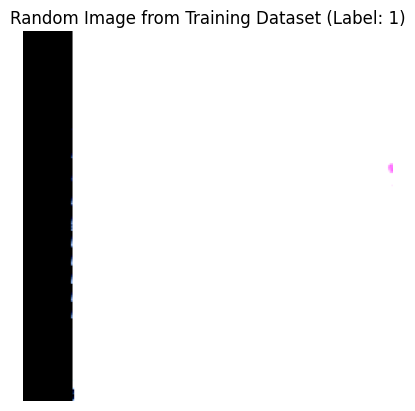

Preprocessed Image Shape: torch.Size([1, 3, 224, 224])
Preprocessed Image Tensor (First Channel):
tensor([[-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
        [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2318,  2.1975],
        [-2.1179, -2.1179, -2.1179,  ...,  2.2318,  2.2489,  2.1975],
        ...,
        [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
        [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
        [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489]],
       device='cuda:0')
Patch Embedding Shape: torch.Size([1, 784, 768])
Transformer Block 1 Output Shape: torch.Size([1, 784, 768])
Transformer Block 2 Output Shape: torch.Size([1, 784, 768])
Transformer Block 3 Output Shape: torch.Size([1, 784, 768])
Transformer Block 4 Output Shape: torch.Size([1, 784, 768])
Transformer Block 5 Output Shape: torch.Size([1, 784, 768])
Transformer Block 6 Output Shape: torch.Size([1, 784, 768])
Transformer Block 7 Output Shape: t

In [10]:
random_image(train_loader_7_Class, backbone_7_class)
random_image(train_loader_4_Class, backbone_4_class)
random_image(train_loader_2_Class, backbone_2_class)

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn as nn
import torch.optim as optim
import time

def train_model(backbone, train_loader, device, class_weights, num_classes):
    backbone.to(device)

    # Freeze the backbone parameters
    for param in backbone.parameters():
        param.requires_grad = False

    # Unfreeze the classification head
    for param in backbone.head.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(backbone.head.parameters(), lr=0.001, weight_decay=1e-5)
    num_epochs = 7

    # Lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        backbone.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        all_train_labels = []
        all_train_predictions = []

        for images, labels in train_loader:

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = backbone(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            # Store predictions and labels for metrics
            all_train_labels.extend(labels.cpu().numpy())
            all_train_predictions.extend(predicted.cpu().numpy())

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        train_precision = precision_score(all_train_labels, all_train_predictions, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_predictions, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

        # Print epoch statistics
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}")
        print(f"  Time Taken: {time.time() - start_time:.2f} seconds")

    # Plot training loss and accuracy curves
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Curve')

    plt.tight_layout()
    plt.show()

    metrics_dict = {
        'model_name': f'Huron Tiny {num_classes} Classes',
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
    }

    print("Final Metrics:", metrics_dict)

    return metrics_dict

Class Counts: Counter({6: 213, 5: 108, 4: 81, 3: 80, 0: 79, 2: 71, 1: 64})
Class Weights: tensor([0.0127, 0.0156, 0.0141, 0.0125, 0.0123, 0.0093, 0.0047],
       device='cuda:0')
Epoch [1/7]
  Train Loss: 0.9913, Train Accuracy: 62.21%
  Train Precision: 0.6299, Train Recall: 0.6221, Train F1 Score: 0.6220
  Time Taken: 7.35 seconds
Epoch [2/7]
  Train Loss: 0.3903, Train Accuracy: 88.07%
  Train Precision: 0.8823, Train Recall: 0.8807, Train F1 Score: 0.8808
  Time Taken: 6.76 seconds
Epoch [3/7]
  Train Loss: 0.2306, Train Accuracy: 92.67%
  Train Precision: 0.9287, Train Recall: 0.9267, Train F1 Score: 0.9270
  Time Taken: 6.74 seconds
Epoch [4/7]
  Train Loss: 0.1894, Train Accuracy: 93.68%
  Train Precision: 0.9401, Train Recall: 0.9368, Train F1 Score: 0.9377
  Time Taken: 6.75 seconds
Epoch [5/7]
  Train Loss: 0.1356, Train Accuracy: 95.83%
  Train Precision: 0.9592, Train Recall: 0.9583, Train F1 Score: 0.9583
  Time Taken: 6.75 seconds
Epoch [6/7]
  Train Loss: 0.0672, Train A

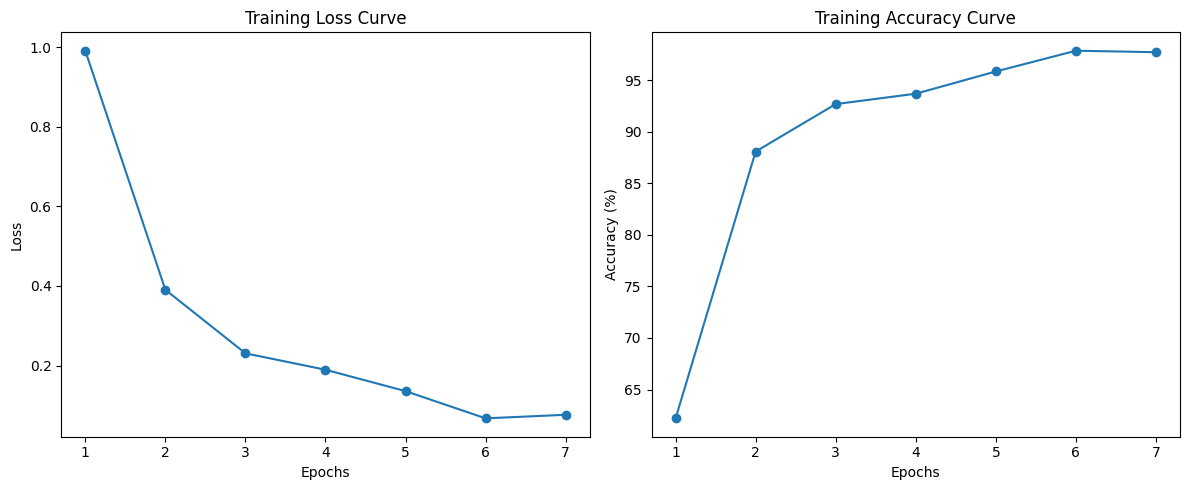

Final Metrics: {'model_name': 'Huron Tiny 7 Classes', 'train_accuracy': 97.70114942528735, 'train_precision': 0.9772657152123291, 'train_recall': 0.9770114942528736, 'train_f1': 0.9770672000749014}


In [12]:
huron_tiny_7_classes_metrics = train_model(backbone_7_class, train_loader_7_Class, device, get_class_weights(train_loader_7_Class), 7)

Class Counts: Counter({3: 215, 2: 106, 0: 81, 1: 55})
Class Weights: tensor([0.0123, 0.0182, 0.0094, 0.0047], device='cuda:0')
Epoch [1/7]
  Train Loss: 0.3431, Train Accuracy: 85.12%
  Train Precision: 0.8602, Train Recall: 0.8512, Train F1 Score: 0.8531
  Time Taken: 4.60 seconds
Epoch [2/7]
  Train Loss: 0.0845, Train Accuracy: 97.37%
  Train Precision: 0.9745, Train Recall: 0.9737, Train F1 Score: 0.9739
  Time Taken: 4.58 seconds
Epoch [3/7]
  Train Loss: 0.0123, Train Accuracy: 99.34%
  Train Precision: 0.9935, Train Recall: 0.9934, Train F1 Score: 0.9934
  Time Taken: 4.58 seconds
Epoch [4/7]
  Train Loss: 0.0331, Train Accuracy: 98.91%
  Train Precision: 0.9891, Train Recall: 0.9891, Train F1 Score: 0.9891
  Time Taken: 4.58 seconds
Epoch [5/7]
  Train Loss: 0.0052, Train Accuracy: 99.78%
  Train Precision: 0.9978, Train Recall: 0.9978, Train F1 Score: 0.9978
  Time Taken: 4.58 seconds
Epoch [6/7]
  Train Loss: 0.0011, Train Accuracy: 100.00%
  Train Precision: 1.0000, Train Re

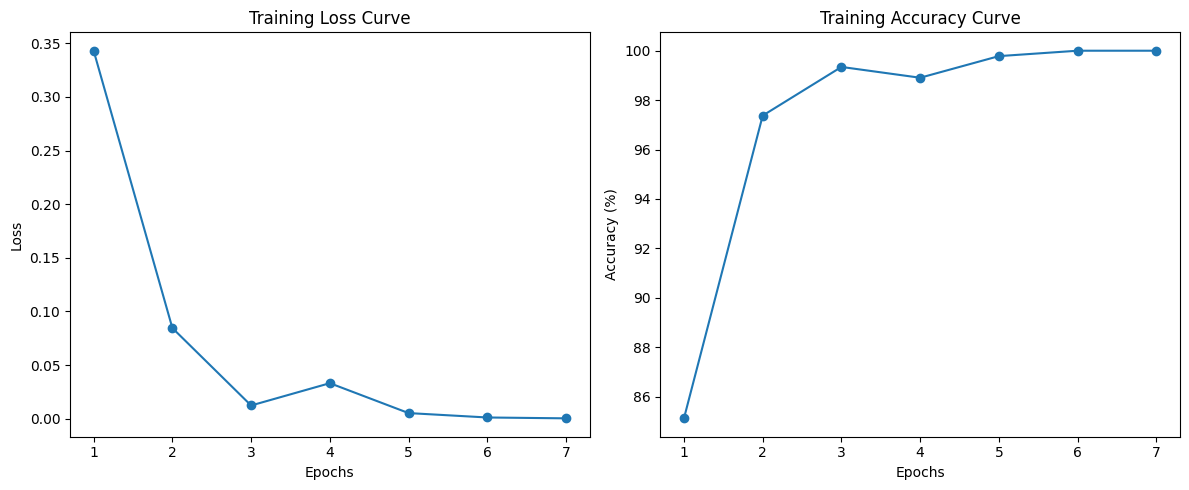

Final Metrics: {'model_name': 'Huron Tiny 4 Classes', 'train_accuracy': 100.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0}


In [13]:
huron_tiny_4_classes_metrics = train_model(backbone_4_class, train_loader_4_Class, device, get_class_weights(train_loader_4_Class), 4)

Class Counts: Counter({1: 88, 0: 83})
Class Weights: tensor([0.0120, 0.0114], device='cuda:0')
Epoch [1/7]
  Train Loss: 0.3531, Train Accuracy: 84.21%
  Train Precision: 0.8424, Train Recall: 0.8421, Train F1 Score: 0.8420
  Time Taken: 1.99 seconds
Epoch [2/7]
  Train Loss: 0.1112, Train Accuracy: 97.66%
  Train Precision: 0.9776, Train Recall: 0.9766, Train F1 Score: 0.9766
  Time Taken: 1.94 seconds
Epoch [3/7]
  Train Loss: 0.0694, Train Accuracy: 97.08%
  Train Precision: 0.9708, Train Recall: 0.9708, Train F1 Score: 0.9708
  Time Taken: 2.07 seconds
Epoch [4/7]
  Train Loss: 0.0179, Train Accuracy: 99.42%
  Train Precision: 0.9942, Train Recall: 0.9942, Train F1 Score: 0.9942
  Time Taken: 1.93 seconds
Epoch [5/7]
  Train Loss: 0.0083, Train Accuracy: 100.00%
  Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000
  Time Taken: 1.94 seconds
Epoch [6/7]
  Train Loss: 0.0026, Train Accuracy: 100.00%
  Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1

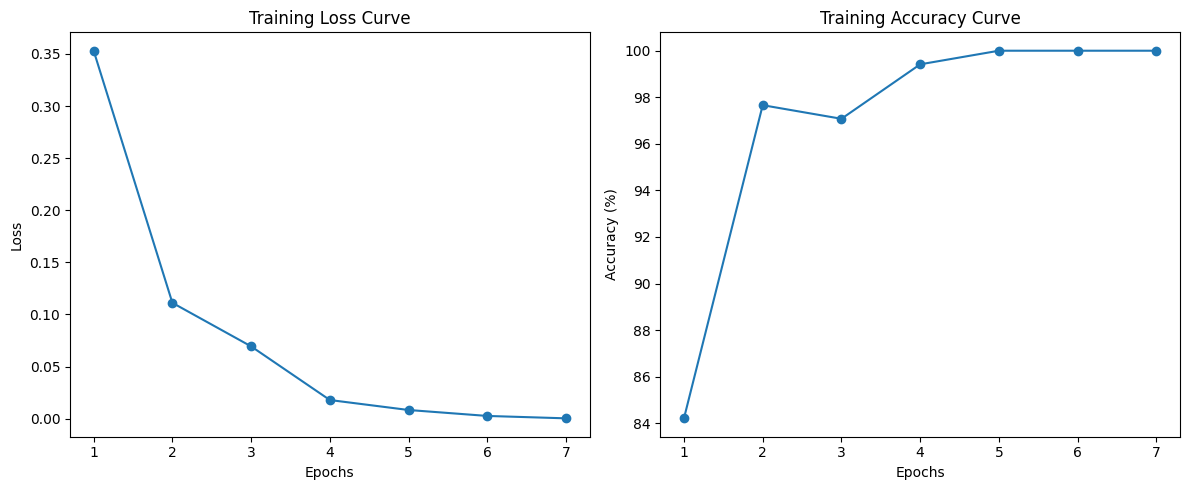

Final Metrics: {'model_name': 'Huron Tiny 2 Classes', 'train_accuracy': 100.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0}


In [14]:
huron_tiny_2_classes_metrics = train_model(backbone_2_class, train_loader_2_Class, device, get_class_weights(train_loader_2_Class), 2)

In [15]:
def save_model(backbone, save_path):
    checkpoint = {
        'model_state_dict': backbone.state_dict(),
    }

    torch.save(checkpoint, save_path)
    print(f"Model saved to {save_path}")
    checkpoint = {
        'model_state_dict': backbone.state_dict(),
    }

    save_path = "/content/checkpoints/final_model_tiny.pth"
    torch.save(checkpoint, save_path)
    print(f"Model saved to {save_path}")

In [16]:
save_model(backbone_7_class, "/content/checkpoints/using_pretrained_dino_7_Class.pth")
save_model(backbone_4_class, "/content/checkpoints/using_pretrained_dino_4_Class.pth")
save_model(backbone_2_class, "/content/checkpoints/using_pretrained_dino_2_Class.pth")

Model saved to /content/checkpoints/using_pretrained_dino_7_Class.pth
Model saved to /content/checkpoints/final_model_tiny.pth
Model saved to /content/checkpoints/using_pretrained_dino_4_Class.pth
Model saved to /content/checkpoints/final_model_tiny.pth
Model saved to /content/checkpoints/using_pretrained_dino_2_Class.pth
Model saved to /content/checkpoints/final_model_tiny.pth


In [17]:
# Combine dictionaries into a list
all_metrics = [huron_tiny_7_classes_metrics,  huron_tiny_2_classes_metrics]

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_metrics)

# Display the table
print("\nMetrics Table:")
print(df)

# Save the DataFrame as an Excel file
output_file = 'model_metrics_train.xlsx'
df.to_excel(output_file, index=False)

print(f"\nMetrics table saved to {output_file}")


Metrics Table:
             model_name  train_accuracy  train_precision  train_recall  \
0  Huron Tiny 7 Classes       97.701149         0.977266      0.977011   
1  Huron Tiny 2 Classes      100.000000         1.000000      1.000000   

   train_f1  
0  0.977067  
1  1.000000  

Metrics table saved to model_metrics_train.xlsx
